In [1]:
import numpy as np
import pandas as pd
import random

import tensorflow as tf
from tensorflow import keras
from keras.models import Model, load_model
from keras.layers import Dense, LSTM, Dropout, Input, Concatenate, Normalization, Conv2D, Flatten


In [2]:
FOLDER_INDEX = 8
PLAN_LENGTH = 50
DATASET_ADDRESS = f'../../bag/log_{FOLDER_INDEX}'

cmdVel = pd.read_csv(
    f'{DATASET_ADDRESS}/cmd_vel_log.csv', delimiter=',').values
heading = pd.read_csv(f'{DATASET_ADDRESS}/heading.csv', delimiter=',').values
costmap = pd.read_csv(f'{DATASET_ADDRESS}/costmap.csv',
                      delimiter=',').values.reshape((-1, 20, 20))
planX = pd.read_csv(f'{DATASET_ADDRESS}/global_plan_x_log.csv',
                    delimiter=',', names=list(range(110)), header=None).values
planY = pd.read_csv(f'{DATASET_ADDRESS}/global_plan_y_log.csv',
                    delimiter=',', names=list(range(110)), header=None).values

print("================================")
print("current data size: \n")
print(cmdVel.shape, planX.shape, planY.shape, heading.shape, costmap.shape)
len = np.amin([cmdVel.shape[0], planX.shape[0], planY.shape[0],
              heading.shape[0], costmap.shape[0]])
cmdVel = cmdVel[:len]
heading = heading[:len]
planX = planX[:len]
planY = planY[:len]
costmap = costmap[:len]
print("reduced to: \n")
print(cmdVel.shape, planX.shape, planY.shape, heading.shape, costmap.shape)

planX = planX[:, :PLAN_LENGTH]
planY = planY[:, :PLAN_LENGTH]

current data size: 

(406340, 2) (406341, 110) (406341, 110) (406340, 2) (406340, 20, 20)
reduced to: 

(406340, 2) (406340, 110) (406340, 110) (406340, 2) (406340, 20, 20)


In [3]:
def emptyRows(arr):
    delList = []
    for r, row in enumerate(arr):
        if np.any(np.isnan(row)):
            delList += [r]
    return delList


delList1 = emptyRows(planX)
delList2 = emptyRows(planY)
assert delList1 == delList2

planX = np.delete(planX, delList1, axis=0)
planY = np.delete(planY, delList1, axis=0)
cmdVel = np.delete(cmdVel, delList1, axis=0)
heading = np.delete(heading, delList1, axis=0)
costmap = np.delete(costmap, delList1, axis=0)

print("================================")
print(f'deleting NaNs; size reduced to:\n {planX.shape[0]}')

assert not np.any(np.isnan(planX))
assert not np.any(np.isnan(planY))
assert not np.any(np.isnan(cmdVel))
assert not np.any(np.isnan(heading))
assert not np.any(np.isnan(costmap))

deleting NaNs; size reduced to:
 306746


In [4]:
print("================================")
print("data range:\n")
print(planX.min().round(5), planX.max().round(5))
print(planY.min().round(5), planY.max().round(5))
print(costmap.min().round(5), costmap.max().round(5))
for i in range(cmdVel.shape[1]):
    print(cmdVel[:, i].min().round(5), cmdVel[:, i].max().round(5))
for i in range(heading.shape[1]):
    print(heading[:, i].min().round(5), heading[:, i].max().round(5))

plan = np.stack([planX, planY], axis=2)

heading = tf.convert_to_tensor(heading)
cmdVel = tf.convert_to_tensor(cmdVel)
plan = tf.convert_to_tensor(plan)
costmap = tf.convert_to_tensor(costmap)

data range:

-1.37155 1.31044
-1.34073 1.32024
0.0 99.88889
-0.22 0.22
-2.77979 2.81163
-0.99999 0.99999
-0.99999 0.99999


In [5]:
print("================================")
print(f"input shape:\n {plan.shape, heading.shape, costmap.shape}\noutput shape:\n {cmdVel.shape}")

validationLength = int(plan.shape[0]*0.05)
print(f'validation length: {validationLength}\n')

planNormalizer = Normalization()
headingNormalizer = Normalization()
costmapNormalizer = Normalization()

planNormalizer.adapt(plan)
headingNormalizer.adapt(heading)
costmapNormalizer.adapt(costmap)


input shape:
 (TensorShape([306746, 50, 2]), TensorShape([306746, 2]), TensorShape([306746, 20, 20]))
output shape:
 (306746, 2)
validation length: 15337



In [10]:
planInput = Input((None, 2))
headingInput = Input((2,))
costmapInput = Input((20, 20, 1))

planNormalized = planNormalizer(planInput)
headingNormalized = headingNormalizer(headingInput)
costmapNormalized = costmapNormalizer(costmapInput)

planLatent = LSTM(32, input_shape=(None, 2), activation='tanh')(planNormalized)
planLatent = Dense(16, activation='tanh')(planLatent)

costmapLatent = Conv2D(16, (3, 3), activation="relu",
                       padding="same", strides=(2, 2))(costmapNormalized)
costmapLatent = Dropout(0.1)(costmapLatent)
costmapLatent = Flatten()(costmapLatent)
costmapLatent = Dense(8, activation="relu")(costmapLatent)

concatLayer = Concatenate()([planLatent, headingNormalized, costmapLatent])

mergedLayer = Dense(16, activation='tanh')(concatLayer)
mergedLayer = Dropout(0.1)(mergedLayer)
mergedLayer = Dense(8, activation='tanh')(mergedLayer)
output = Dense(2, activation='tanh')(mergedLayer)

model = Model(inputs=[planInput, headingInput, costmapInput], outputs=output)


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 20, 20, 1)]  0           []                               
                                                                                                  
 normalization_2 (Normalization  (None, 20, 20, 20)  41          ['input_6[0][0]']                
 )                                                                                                
                                                                                                  
 input_4 (InputLayer)           [(None, None, 2)]    0           []                               
                                                                                                  
 conv2d_1 (Conv2D)              (None, 10, 10, 16)   2896        ['normalization_2[1][0]']  

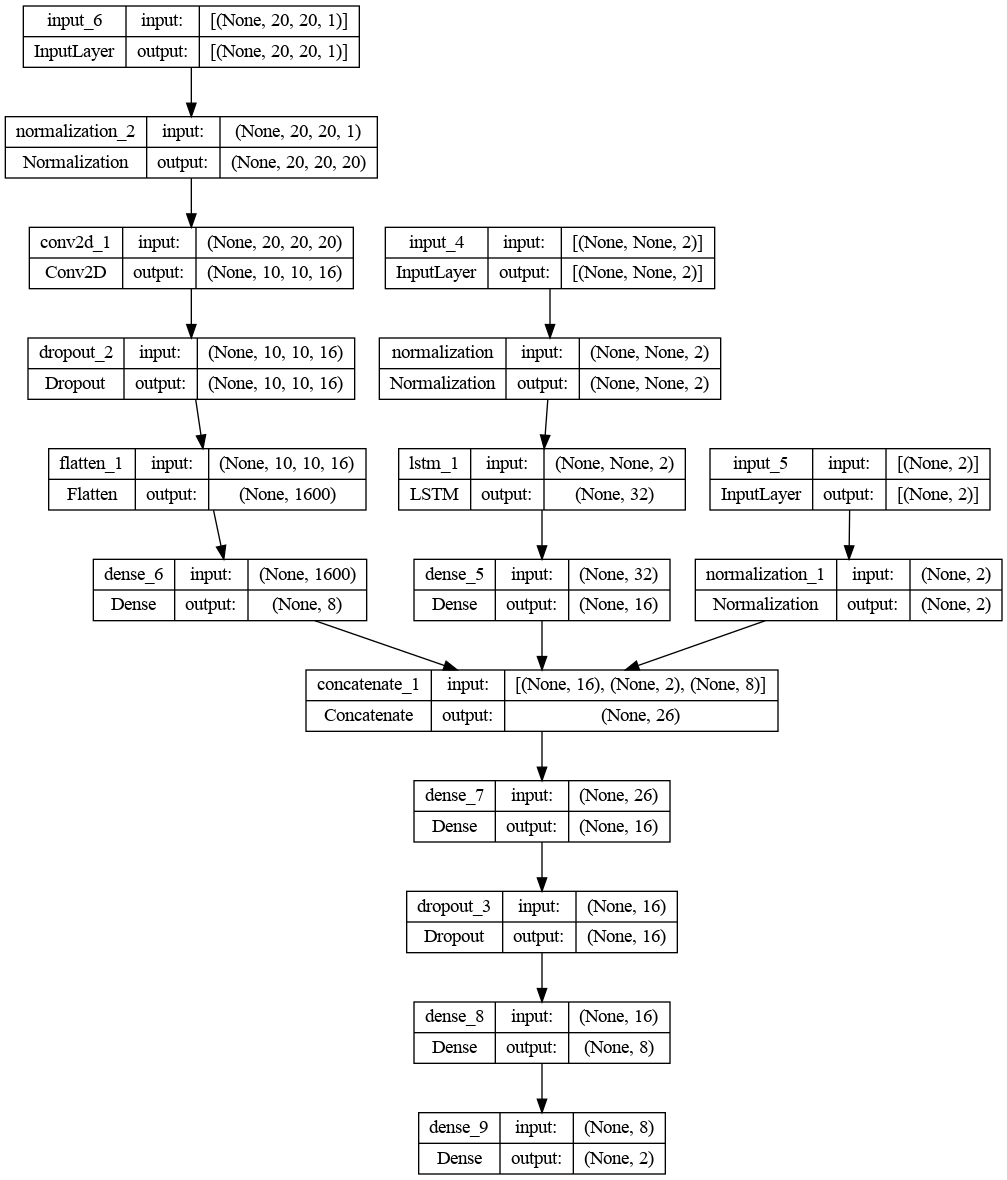

In [11]:
model.compile(loss='mse',
              optimizer=tf.keras.optimizers.SGD(
                  learning_rate=1e-2, decay=1e-6, momentum=0.9, nesterov=True),
              metrics=['accuracy'])
print("================================")
print("================================")
print("================================")

model.summary()
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)


In [12]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=f'{DATASET_ADDRESS}/checkpoint',
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)


In [13]:
model.fit(
    x=[plan[:-validationLength],
      heading[:-validationLength],
      costmap[:-validationLength]],
    y=cmdVel[:-validationLength],
    epochs=150,
    batch_size=128,
    validation_split=0.2,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/150
1821/1822 [============================>.] - ETA: 0s - loss: 0.1936 - accuracy: 0.5674

INFO:tensorflow:Assets written to: ../../bag/log_8/checkpoint/assets


INFO:tensorflow:Assets written to: ../../bag/log_8/checkpoint/assets


1822/1822 [==============================] - 46s 25ms/step - loss: 0.1936 - accuracy: 0.5674 - val_loss: 0.2058 - val_accuracy: 0.5476
Epoch 2/150
1822/1822 [==============================] - 41s 22ms/step - loss: 0.1903 - accuracy: 0.5687 - val_loss: 0.2076 - val_accuracy: 0.5484
Epoch 3/150
1821/1822 [============================>.] - ETA: 0s - loss: 0.1880 - accuracy: 0.5711

INFO:tensorflow:Assets written to: ../../bag/log_8/checkpoint/assets


INFO:tensorflow:Assets written to: ../../bag/log_8/checkpoint/assets


1822/1822 [==============================] - 44s 24ms/step - loss: 0.1880 - accuracy: 0.5712 - val_loss: 0.2032 - val_accuracy: 0.5607
Epoch 4/150
1822/1822 [==============================] - ETA: 0s - loss: 0.1835 - accuracy: 0.5758

INFO:tensorflow:Assets written to: ../../bag/log_8/checkpoint/assets


INFO:tensorflow:Assets written to: ../../bag/log_8/checkpoint/assets


1822/1822 [==============================] - 44s 24ms/step - loss: 0.1835 - accuracy: 0.5758 - val_loss: 0.1976 - val_accuracy: 0.5763
Epoch 5/150
1821/1822 [============================>.] - ETA: 0s - loss: 0.1763 - accuracy: 0.6001

INFO:tensorflow:Assets written to: ../../bag/log_8/checkpoint/assets


INFO:tensorflow:Assets written to: ../../bag/log_8/checkpoint/assets


1822/1822 [==============================] - 44s 24ms/step - loss: 0.1764 - accuracy: 0.6001 - val_loss: 0.1889 - val_accuracy: 0.6300
Epoch 6/150
1821/1822 [============================>.] - ETA: 0s - loss: 0.1659 - accuracy: 0.6457

INFO:tensorflow:Assets written to: ../../bag/log_8/checkpoint/assets


INFO:tensorflow:Assets written to: ../../bag/log_8/checkpoint/assets


1822/1822 [==============================] - 44s 24ms/step - loss: 0.1659 - accuracy: 0.6457 - val_loss: 0.1733 - val_accuracy: 0.6803
Epoch 7/150
1820/1822 [============================>.] - ETA: 0s - loss: 0.1564 - accuracy: 0.6852

INFO:tensorflow:Assets written to: ../../bag/log_8/checkpoint/assets


INFO:tensorflow:Assets written to: ../../bag/log_8/checkpoint/assets


1822/1822 [==============================] - 45s 24ms/step - loss: 0.1564 - accuracy: 0.6852 - val_loss: 0.1673 - val_accuracy: 0.7124
Epoch 8/150
1822/1822 [==============================] - ETA: 0s - loss: 0.1512 - accuracy: 0.7024

INFO:tensorflow:Assets written to: ../../bag/log_8/checkpoint/assets


INFO:tensorflow:Assets written to: ../../bag/log_8/checkpoint/assets


1822/1822 [==============================] - 44s 24ms/step - loss: 0.1512 - accuracy: 0.7024 - val_loss: 0.1646 - val_accuracy: 0.7164
Epoch 9/150
1822/1822 [==============================] - ETA: 0s - loss: 0.1476 - accuracy: 0.7130

INFO:tensorflow:Assets written to: ../../bag/log_8/checkpoint/assets


INFO:tensorflow:Assets written to: ../../bag/log_8/checkpoint/assets


1822/1822 [==============================] - 44s 24ms/step - loss: 0.1476 - accuracy: 0.7130 - val_loss: 0.1632 - val_accuracy: 0.7059
Epoch 10/150
1821/1822 [============================>.] - ETA: 0s - loss: 0.1444 - accuracy: 0.7212

INFO:tensorflow:Assets written to: ../../bag/log_8/checkpoint/assets


INFO:tensorflow:Assets written to: ../../bag/log_8/checkpoint/assets


1822/1822 [==============================] - 44s 24ms/step - loss: 0.1444 - accuracy: 0.7212 - val_loss: 0.1623 - val_accuracy: 0.7105
Epoch 11/150
1821/1822 [============================>.] - ETA: 0s - loss: 0.1418 - accuracy: 0.7237

INFO:tensorflow:Assets written to: ../../bag/log_8/checkpoint/assets


INFO:tensorflow:Assets written to: ../../bag/log_8/checkpoint/assets


1822/1822 [==============================] - 44s 24ms/step - loss: 0.1418 - accuracy: 0.7237 - val_loss: 0.1609 - val_accuracy: 0.7206
Epoch 12/150
1822/1822 [==============================] - 41s 22ms/step - loss: 0.1397 - accuracy: 0.7312 - val_loss: 0.1620 - val_accuracy: 0.7173
Epoch 13/150
1822/1822 [==============================] - 41s 23ms/step - loss: 0.1380 - accuracy: 0.7345 - val_loss: 0.1639 - val_accuracy: 0.7071
Epoch 14/150
1822/1822 [==============================] - ETA: 0s - loss: 0.1366 - accuracy: 0.7354

INFO:tensorflow:Assets written to: ../../bag/log_8/checkpoint/assets


INFO:tensorflow:Assets written to: ../../bag/log_8/checkpoint/assets


1822/1822 [==============================] - 44s 24ms/step - loss: 0.1366 - accuracy: 0.7354 - val_loss: 0.1605 - val_accuracy: 0.7330
Epoch 15/150
1822/1822 [==============================] - 41s 23ms/step - loss: 0.1348 - accuracy: 0.7394 - val_loss: 0.1632 - val_accuracy: 0.7098
Epoch 16/150
1822/1822 [==============================] - 41s 23ms/step - loss: 0.1333 - accuracy: 0.7413 - val_loss: 0.1612 - val_accuracy: 0.7311
Epoch 17/150
1822/1822 [==============================] - ETA: 0s - loss: 0.1320 - accuracy: 0.7455

INFO:tensorflow:Assets written to: ../../bag/log_8/checkpoint/assets


INFO:tensorflow:Assets written to: ../../bag/log_8/checkpoint/assets


1822/1822 [==============================] - 45s 24ms/step - loss: 0.1320 - accuracy: 0.7455 - val_loss: 0.1599 - val_accuracy: 0.7336
Epoch 18/150
1820/1822 [============================>.] - ETA: 0s - loss: 0.1309 - accuracy: 0.7473

INFO:tensorflow:Assets written to: ../../bag/log_8/checkpoint/assets


INFO:tensorflow:Assets written to: ../../bag/log_8/checkpoint/assets


1822/1822 [==============================] - 45s 24ms/step - loss: 0.1308 - accuracy: 0.7473 - val_loss: 0.1594 - val_accuracy: 0.7523
Epoch 19/150
1822/1822 [==============================] - 41s 23ms/step - loss: 0.1296 - accuracy: 0.7497 - val_loss: 0.1621 - val_accuracy: 0.7247
Epoch 20/150
1822/1822 [==============================] - 41s 23ms/step - loss: 0.1282 - accuracy: 0.7516 - val_loss: 0.1634 - val_accuracy: 0.7267
Epoch 21/150
1822/1822 [==============================] - 41s 23ms/step - loss: 0.1274 - accuracy: 0.7535 - val_loss: 0.1631 - val_accuracy: 0.7267
Epoch 22/150
1822/1822 [==============================] - 41s 23ms/step - loss: 0.1264 - accuracy: 0.7541 - val_loss: 0.1630 - val_accuracy: 0.7385
Epoch 23/150
1822/1822 [==============================] - 41s 23ms/step - loss: 0.1254 - accuracy: 0.7576 - val_loss: 0.1612 - val_accuracy: 0.7361
Epoch 24/150
1820/1822 [============================>.] - ETA: 0s - loss: 0.1244 - accuracy: 0.7592

INFO:tensorflow:Assets written to: ../../bag/log_8/checkpoint/assets


INFO:tensorflow:Assets written to: ../../bag/log_8/checkpoint/assets


1822/1822 [==============================] - 45s 24ms/step - loss: 0.1244 - accuracy: 0.7593 - val_loss: 0.1591 - val_accuracy: 0.7509
Epoch 25/150
1822/1822 [==============================] - 41s 22ms/step - loss: 0.1239 - accuracy: 0.7616 - val_loss: 0.1624 - val_accuracy: 0.7498
Epoch 26/150
1822/1822 [==============================] - 41s 23ms/step - loss: 0.1228 - accuracy: 0.7629 - val_loss: 0.1611 - val_accuracy: 0.7473
Epoch 27/150
1822/1822 [==============================] - 41s 23ms/step - loss: 0.1222 - accuracy: 0.7640 - val_loss: 0.1600 - val_accuracy: 0.7419
Epoch 28/150
1822/1822 [==============================] - 41s 22ms/step - loss: 0.1215 - accuracy: 0.7657 - val_loss: 0.1612 - val_accuracy: 0.7503
Epoch 29/150
1822/1822 [==============================] - 41s 23ms/step - loss: 0.1211 - accuracy: 0.7664 - val_loss: 0.1643 - val_accuracy: 0.7429
Epoch 30/150
1822/1822 [==============================] - 41s 23ms/step - loss: 0.1198 - accuracy: 0.7681 - val_loss: 0.1614 

1822/1822 [==============================] - 42s 23ms/step - loss: 0.1071 - accuracy: 0.7882 - val_loss: 0.1626 - val_accuracy: 0.7695
Epoch 80/150
1822/1822 [==============================] - 41s 23ms/step - loss: 0.1072 - accuracy: 0.7870 - val_loss: 0.1636 - val_accuracy: 0.7548
Epoch 81/150
1822/1822 [==============================] - 42s 23ms/step - loss: 0.1072 - accuracy: 0.7881 - val_loss: 0.1641 - val_accuracy: 0.7505
Epoch 82/150
1822/1822 [==============================] - 42s 23ms/step - loss: 0.1067 - accuracy: 0.7877 - val_loss: 0.1623 - val_accuracy: 0.7634
Epoch 83/150
1822/1822 [==============================] - 42s 23ms/step - loss: 0.1070 - accuracy: 0.7878 - val_loss: 0.1629 - val_accuracy: 0.7623
Epoch 84/150
1822/1822 [==============================] - 42s 23ms/step - loss: 0.1066 - accuracy: 0.7880 - val_loss: 0.1620 - val_accuracy: 0.7621
Epoch 85/150
1822/1822 [==============================] - 42s 23ms/step - loss: 0.1066 - accuracy: 0.7880 - val_loss: 0.1633 

INFO:tensorflow:Assets written to: ../../bag/log_8/checkpoint/assets


INFO:tensorflow:Assets written to: ../../bag/log_8/checkpoint/assets


1822/1822 [==============================] - 48s 26ms/step - loss: 0.1034 - accuracy: 0.7916 - val_loss: 0.1568 - val_accuracy: 0.7723
Epoch 110/150
1822/1822 [==============================] - 42s 23ms/step - loss: 0.1032 - accuracy: 0.7924 - val_loss: 0.1627 - val_accuracy: 0.7568
Epoch 111/150
1822/1822 [==============================] - 42s 23ms/step - loss: 0.1050 - accuracy: 0.7877 - val_loss: 0.1626 - val_accuracy: 0.7540
Epoch 112/150
1822/1822 [==============================] - 42s 23ms/step - loss: 0.1048 - accuracy: 0.7885 - val_loss: 0.1622 - val_accuracy: 0.7646
Epoch 113/150
1822/1822 [==============================] - 42s 23ms/step - loss: 0.1047 - accuracy: 0.7915 - val_loss: 0.1653 - val_accuracy: 0.7556
Epoch 114/150
1822/1822 [==============================] - 42s 23ms/step - loss: 0.1045 - accuracy: 0.7925 - val_loss: 0.1631 - val_accuracy: 0.7608
Epoch 115/150
1822/1822 [==============================] - 42s 23ms/step - loss: 0.1041 - accuracy: 0.7917 - val_loss: 0

In [14]:
q = model.evaluate(x=[plan[-validationLength:], heading[-validationLength:], costmap[-validationLength:]],
                   y=cmdVel[-validationLength:],
                   batch_size=128)
q = int(np.array(q).round(2)[1]*100)
print("================================")
print(f"evaluation accurecy: {q}%")

address = f"{DATASET_ADDRESS}/deepMPCModel{q}"
model.save(filepath=address,
           overwrite=True, include_optimizer=True)
model = load_model(address)

120/120 [==============================] - 1s 8ms/step - loss: 0.1683 - accuracy: 0.7806
evaluation accurecy: 78%


INFO:tensorflow:Assets written to: ../../bag/log_8/deepMPCModel78/assets


INFO:tensorflow:Assets written to: ../../bag/log_8/deepMPCModel78/assets


In [15]:
i = random.randint(0, plan.shape[0]-1)
vel = model.predict([plan[None, i], heading[None, i], costmap[None, i]])
print(f"sample predicted output: {vel}")

1/1 [==============================] - 1s 1s/step
sample predicted output: [[ 0.20998025 -0.02068261]]
